# R-Simmer
## Cafe Sim
The required `simmer` package, which is used for discrete-event simulation installed. `simmer` and `parallel` libraries were loaded.

### 1. Install and Import Libraries

In [8]:
# Install required package
install.packages("simmer")

library(simmer) # Simmer package imported
library(parallel) # Import to parallelize

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 2. Barista and Service Time
The parameters for service times, mean (`M_order` and `M_barista`) defined with reasonable numbers to generate order and service time.

In [9]:
# Number of baristas
num_baristas <- 2

# Parameters for service times (mean and standard deviation)
SD_order <- 0.2
M_order <- 0.1
SD_barista <- 0.5
M_barista <- 0.2

# Functions to generate service times for each stage
generate_order_time <- function() {
  return(rnorm(1, mean = M_order, sd = SD_order))
}

generate_barista_service_time <- function() {
  return(rnorm(1, mean = M_barista, sd = SD_barista))
}

### 3. Simulation Environment
Definition of a trajectory consisting of ordering and service, setup of parallelized environment with resource (barista) and generator (customer).

In [10]:
# For reproducibility
set.seed(400)

# Combined trajectory for ordering and barista service
customer_trajectory <- trajectory("customer_trajectory") %>%
  # Ordering step
  timeout(generate_order_time()) %>%
  # Barista service step
  select("Barista") %>%
  seize_selected() %>%
  timeout(generate_barista_service_time()) %>%
  release_selected()

# Create sequence for customer arrivals per minute
L_values <- seq(0.1, 3, 0.1)

# Parallelize and assign to simmer environment
envs <- mclapply(L_values, function(L) {
  simmer("envs") %>%
    # Adding the barista resource
    add_resource("Barista", num_baristas) %>%
    # Adding the customer generator
    add_generator("Customer", customer_trajectory, function() rexp(1, L)) %>%
    # Run simulation 10_000 time units
    run(10000) %>%
    # Finalize the simulation
    wrap()
})

### 4. Monitoring Arrivals and Waiting Time
Obtain the data on the arrivals in environment and calculate waiting time.

For each replication, `mean_waiting_time` were calculated over each replication index `i`.

In [11]:
# Monitoring arrivals of envs environment to obtain waiting time
results <- get_mon_arrivals(envs) %>%
  transform(waiting_time = end_time - start_time - activity_time)

# Calculates mean waiting time for each replication
mean_waiting_time <- c()
for (i in 1:max(results$replication)) {
  mean_waiting_time[i] <- mean(results$waiting_time[results$replication == i])
}

### 5. Mean Waiting Time vs Customer Arrivals
Plotted the relation between mean waiting time and customer arrivals per minute.

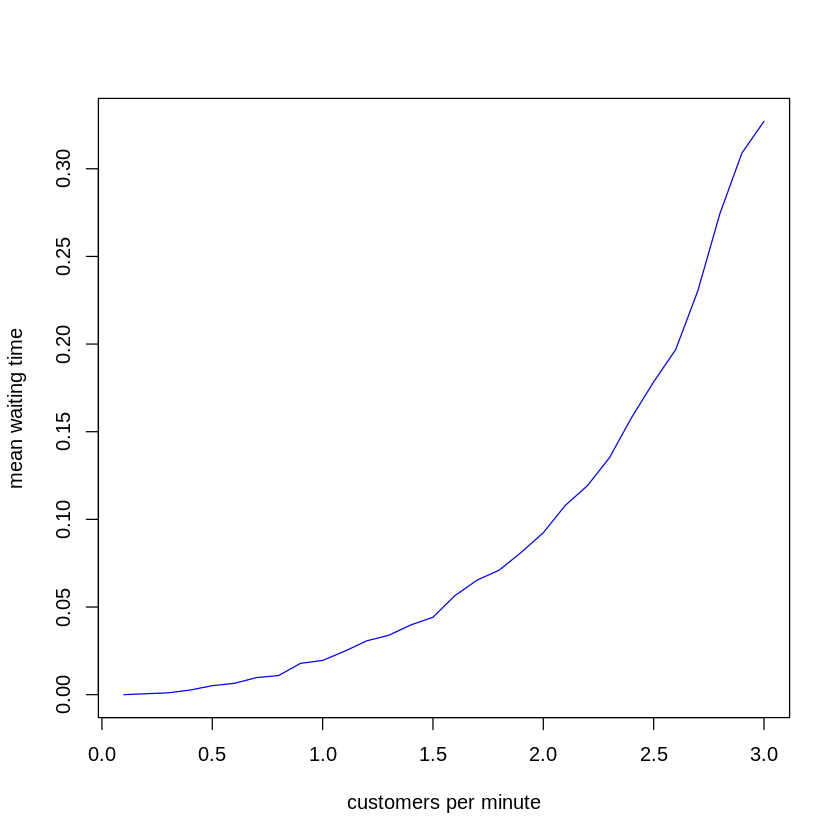

In [12]:
# Plot the relation between mean waiting time and customer arrivals per minute
plot(L_values, mean_waiting_time, type="l", col="blue",
     xlab="customers per minute",
     ylab="mean waiting time")

### 6. Conclusion

The plot generated shows that increasing number of customers per minute have an exponential impact over mean waiting time.